### 서비스 제작을 위한 AI 모델 제작

- 이 페이지는 16차시에서 수행한 분류모델 제작을 기반으로
- Github와 Streamlit을 활용한 이미지 분류 서비스를 만들기 위해
- 기반이 되는 모델을 만드는 과정을 정리한 페이지입니다.
- 다음 절차와 첨부한 영상을 토대로 여러분의 서비스에 적합한 모델을 만들어서 저장하시기 바랍니다.

In [ ]:
#fastai2 라이브러리 설치
!pip install fastai2

#한글 폰트 처리를 위한 라이브러리 설치
!pip install koreanize-matplotlib

#fastbook 라이브러리 설치 및 불러오기
#실행이 안되면 다시 실행할 것~

!pip install -Uqq fastbook

In [ ]:
#코드가 드라이브에 접근할 수 있도록 허용해주는 코드
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# fastbook 라이브러리에서 모든 도구들을 가져온다
# fastai.viwison.widgets에서 모든 도구들을 가져온다.
# 한글 폰트 처리를 위한 도구를 가져온다.

import fastbook
from fastbook import *
from fastai.vision.widgets import *
import koreanize_matplotlib

In [ ]:
# 분류할 type을 key_types에 문자열로 저장한다. (기본은 3개로 되어 있지만 마음대로 바꿔도 됨)
key_types = '','',''
# 드라이브에 사진을 저장할 기본 폴더를 만든 후 이를 경로로 지정한다
path = Path('/content/drive/MyDrive/AI기초 서비스 수행(이미지_데이터/')
# 만약 path에 저장된 경로가 없으면 경로를 만들어준다
if not path.exists() :
  path.mkdir()

In [ ]:
#o라는 이름으로 key_type을 돌면서
for o in key_types :
  print(path, o) # 확인용
  dest = (path/o) #각각의 키워드에 따라 사진을 저장할 폴더 경로
  print(dest) # 확인용
  dest.mkdir(exist_ok = True) #폴더가 없으면 폴더를 만들고
  results = search_images_ddg(o,max_images=200) #키워드에 해당하는 이미지 주소를 가져오고 (최대 이미지 200)
  download_images(dest, urls = results) #설정한 경로에 내용을 파일로 저장한다.

In [ ]:
#모든 사진파일 정보 확인
fns = get_image_files(path)
fns
#왜 600개가 아닐까?

In [ ]:
# 모든 사진파일의 경로가 들어있는 fns를 검증하여 실패한 사진의 경로만 따로 저장함
failed = verify_images(fns)
failed

In [ ]:
# 다운에 실패한 이미지의 위치를 Path에서 제거함
failed.map(Path.unlink)

In [ ]:
#추가로 유효하지 않은 이미지를 삭제함(하드웨어적 파일!!! )

from fastai.vision.all import *
import os
from PIL import UnidentifiedImageError


# 데이터셋에 있는 이미지 경로를 가져오기 (재귀적으로 하위 폴더 포함)
image_files = get_image_files(path)

# 유효하지 않은 이미지를 제거하는 함수
def remove_invalid_images(image_files):
    invalid_images = []
    for file in image_files:
        try:
            # 이미지를 열어보기 (Pillow 사용)
            img = PILImage.create(file)  # 이미지 로드 시도
        except (UnidentifiedImageError, OSError):  # 유효하지 않은 이미지 감지
            invalid_images.append(file)

    # 유효하지 않은 이미지 삭제
    for img in invalid_images:
        try:
            os.remove(img)  # 파일 삭제
            print(f"Removed invalid image: {img}")
        except Exception as e:
            print(f"Failed to remove {img}: {e}")

    return invalid_images

# 유효하지 않은 이미지 제거
invalid_images = remove_invalid_images(image_files)

# 결과 출력
print(f"Total invalid images removed: {len(invalid_images)}")


### 학습 데이터 전처리하기

* 훌륭한 모델을 만들기 위해서는
* 양질의 데이터(분류 모델이 정답을 맞히기 위해 핵심적이고 정확한 의미를 가진 데이터)만을 학습에 사용하는 것이 필요하다.
* 구글 드라이브로 접근해서 /content/drive/MyDrive/AI기초 서비스 수행(이미지_데이터/에 있는 폴더에서 학습에 적당하지 않은 데이터를 삭제해주자!!!

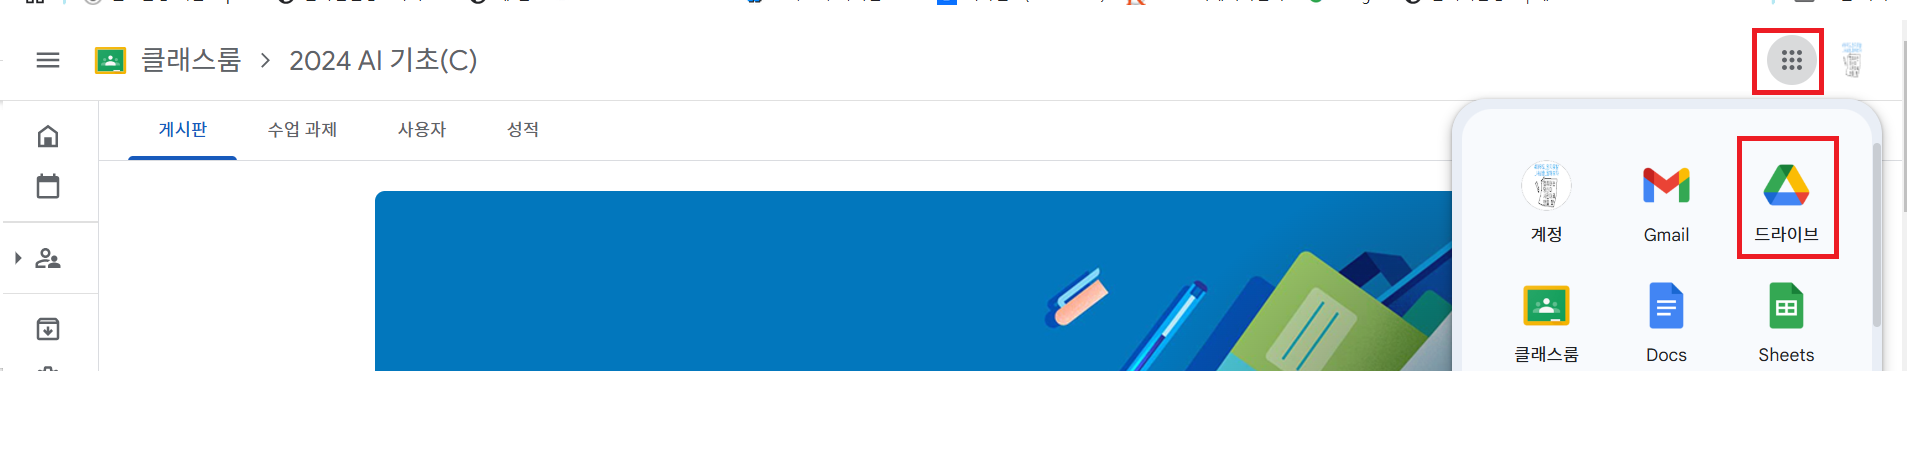

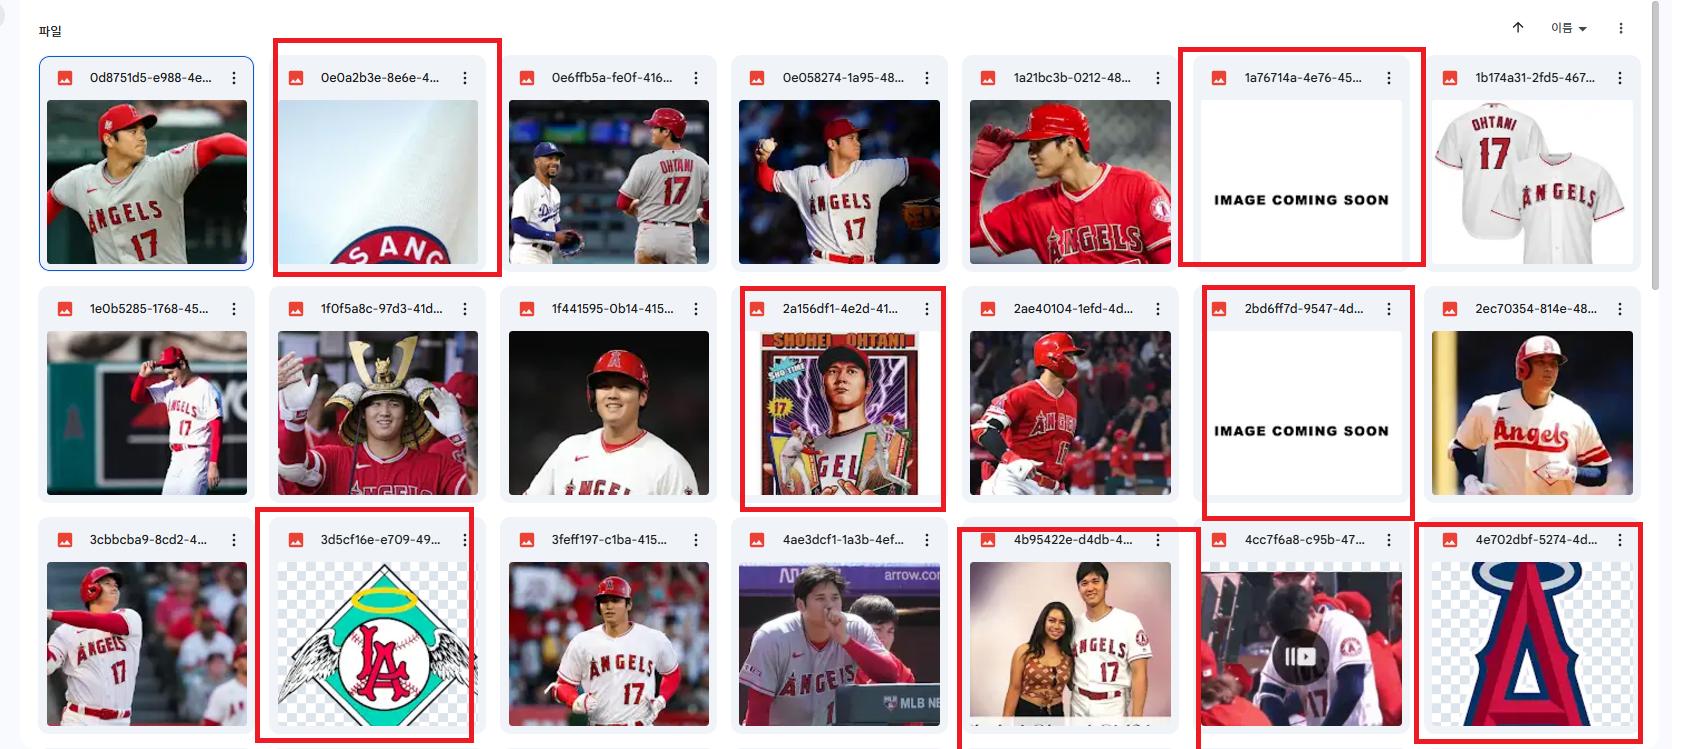

### AI 모델 만들고 저장하기

* 학습 데이터를 모으고 전처리했다면
* 이제 학습방법과 학습횟수를 결정해 모델을 만들고
* 이를 pkl 파일로 저장하고 확인하는 일만 남았다!!!!
* 이 과정을 수행해보자!
* FastAi 모델 학습에 대한 안내 https://fastai1.fast.ai/vision.learner.html
* learn.fine_tune에 대한 안내 https://docs.fast.ai/callback.schedule.html#Learner.fine_tune

In [ ]:
typetools = DataBlock(blocks = (ImageBlock, CategoryBlock), #독립변수(데이터), 종속변수(데이터의 정답)
                   get_items = get_image_files, #파일 경로 설정
                   splitter = RandomSplitter(valid_pct =0.2  , seed = 42 ), #검증 파일 비율 20% 랜덤, seed값 난수 고정(42), 20%는 공부하는데 쓰이는게 아니라 테스트하는데 사용됨. -> 본인이 생각하고 수정해도 됨
                   get_y = parent_label, #파일이 저장된 폴더명을 레이블로 사용
                   item_tfms = Resize(128)) #사이즈 통일

#typetools에는 학습을 위한 기본 조건이 들어간다. (공부법)

In [ ]:
#공부법에 실제 데이터를 적용한다
#예) 50분 공부하고 10분 쉬고 암기로 공부하는 방법을 -> 영어단어에 적용한다.

dls = typetools.dataloaders(path) #공부방법.dataloaders(공부과목)

In [ ]:
#검증 데이터의 값 출력해서 확인하기
dls.train.show_batch(max_n =8  ,nrows =2  ) #n개의 값을 n개의 줄에 나누어 출력한다.


In [ ]:
# 딥러닝 이미지 AI 모델인 cnn중 resnet18을 사용하여 학습할 때마다 학습 오차를 보여주도록 learn 개체를 생성하고
# 학습을 진행한다.
# CNN (컨볼루션 뉴럴 네트워크, 이미지 분류 딥러닝 모델 중 하나)
# CNN을 활용하여 다양한 이미지 데이터용 딥러닝 모델이 만들어졌으며 FastAI에서 제공하는 CNN은
# 다음과 같다
# resnet18, resnet34, resnet50, resnet101, resnet152
# squeezenet1_0, squeezenet1_1
# densenet121, densenet169, densenet201, densenet161
# vgg16_bn, vgg19_bn
# alexnet


learn = vision_learner(dls,resnet34,metrics=error_rate) #이미지 식별 딥러닝 모델의 이름을 입력하기
learn.fine_tune(10)

In [ ]:
#분류 학습의 결과를 시각적으로 보여주는 오차행렬을 생성한 후 보여준다.
interp = ClassificationInterpretation.from_learner(learn) #괄호 안에 모델 이름 집어넣기
interp.plot_confusion_matrix()

In [ ]:
# 값을 다 더하면 그 값의 크기는?
len(dls.valid.items)

73

In [ ]:
# 학습하는 데 사용한 데이터의 크기는?
len(dls.train.items)

294

In [ ]:
#가장 오차가 큰 값 20개를 보여줌
interp.plot_top_losses(20, nrows=5) #n개의 값을 n개의 줄에 표시하기

#예측값/실제값/오차/가능성

### 모델 파일로 저장하기!!!

* 모델을 만들었다면 이제 서비스에 쓸 수 있도록 모델을 파일로 저장할 차례다
* 여러분의 드라이브 경로에 pkl 파일로 여러분들의 모델을 저장하도록 하자!!

In [ ]:
#학습한 모델의 정보를 파일로 생성하기 확장자 .pkl
learn.export('/content/drive/MyDrive/')

In [ ]:
#파일을 통해서 모델 불러오기

learn_inf = load_learner('')

In [ ]:
# 모델 정보 확인하기

learn_inf.dls.vocab